<a href="https://colab.research.google.com/github/Siddhant254/Shoppin-Project/blob/main/BoVW_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python scikit-learn matplotlib


In [2]:
import cv2
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip


--2025-01-27 15:20:05--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-01-27 15:20:05--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  17.1MB/s    in 13s     

2025-01-27 15:20:18 (18.3 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
# Define paths
base_path = "tiny-imagenet-200"
train_path = os.path.join(base_path, "train")

# Collect image paths
image_paths = []
for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.endswith(".JPEG"):
            image_paths.append(os.path.join(root, file))

print(f"Number of images: {len(image_paths)}")


Number of images: 100000


In [5]:
def extract_sift_features(image_paths):
    sift = cv2.SIFT_create()
    descriptors_list = []

    for image_path in tqdm(image_paths, desc="Extracting SIFT features"):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        if image is None:
            continue
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)

    return descriptors_list

# Extract descriptors
descriptors_list = extract_sift_features(image_paths)


Extracting SIFT features: 100%|██████████| 100000/100000 [05:00<00:00, 332.90it/s]


In [8]:
def create_vocabulary(descriptors_list, num_clusters=5):
    # Stack all descriptors into a single array
    all_descriptors = np.vstack(descriptors_list)

    # Cluster descriptors using K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(all_descriptors)

    return kmeans

# Create visual vocabulary
num_clusters = 5
kmeans = create_vocabulary(descriptors_list, num_clusters=num_clusters)


In [9]:
def compute_histograms(descriptors_list, kmeans, num_clusters):
    histograms = []

    for descriptors in tqdm(descriptors_list, desc="Computing histograms"):
        histogram = np.zeros(num_clusters)
        if descriptors is not None:
            cluster_indices = kmeans.predict(descriptors)
            for idx in cluster_indices:
                histogram[idx] += 1
        histograms.append(histogram)

    return np.array(histograms)

# Compute histograms for all images
histograms = compute_histograms(descriptors_list, kmeans, num_clusters)


Computing histograms: 100%|██████████| 99884/99884 [00:26<00:00, 3824.48it/s]


In [10]:
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(histograms)


NearestNeighbors(metric='cosine')

In [11]:
def show_similar_images(query_image_path, knn, histograms, kmeans, image_paths):
    # Extract SIFT descriptors for the query image
    query_image = cv2.imread(query_image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(query_image, None)

    # Compute histogram for the query image
    histogram = np.zeros(num_clusters)
    if descriptors is not None:
        cluster_indices = kmeans.predict(descriptors)
        for idx in cluster_indices:
            histogram[idx] += 1

    # Find similar images using KNN
    distances, indices = knn.kneighbors([histogram])

    # Plot the query image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 6, 1)
    plt.imshow(query_image, cmap="gray")
    plt.title("Query Image")
    plt.axis("off")

    # Plot the similar images
    for i, idx in enumerate(indices[0]):
        similar_image = cv2.imread(image_paths[idx])
        similar_image = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 6, i + 2)
        plt.imshow(similar_image)
        plt.title(f"Similar {i+1}")
        plt.axis("off")
    plt.show()


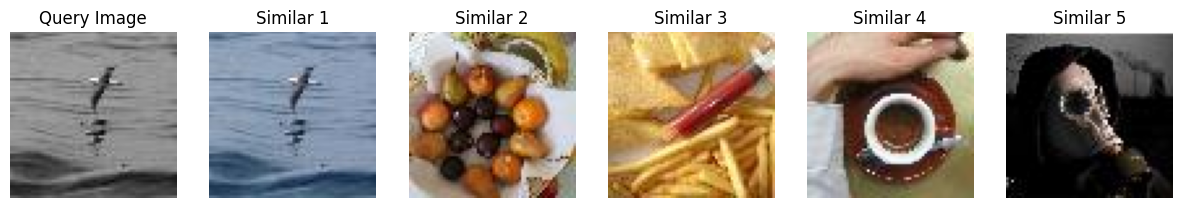

In [12]:
# Path to a query image
query_image_path = image_paths[0]  # Use the first image as a query

# Display similar images
show_similar_images(query_image_path, knn, histograms, kmeans, image_paths)
